## Punctate metric is biasing genes with fewer spots per cell to have more punctate scores

Same issue with radial metric

Definitely occuring when the number of spots, m = 1

Not sure actually if this is occuring when m > 1, but I'll test that now

I've added a method to the Cell class to filter out genes with counts below a threshold

In [57]:
import importlib
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import SRRS
from SRRS import scoring, metrics, plotting

importlib.reload(SRRS)
importlib.reload(metrics)
importlib.reload(scoring)
importlib.reload(plotting)

sample = SRRS.HDF5('../inputs/m1s1_subset.hdf5')
sample.num_cells

152

In [58]:
%%time
#fast
unfilt_cells = [c for c in sample.iter_cells() if c.n > 300]
unfilt_scored_cells = list(scoring._iter_scores(unfilt_cells, metric_name='radial', processes=3))

len(unfilt_scored_cells)

CPU times: user 2.03 s, sys: 82 ms, total: 2.12 s
Wall time: 2.8 s


73

In [59]:
%%time

#slow since gene_vars need to be recalculated
min_gene_spots = 2
filt_cells = [c.filter_low_count_genes(min_gene_spots) for c in sample.iter_cells() if c.n > 300]

filt_cells = scoring._iter_vars(filt_cells)    
filt_scored_cells = list(scoring._iter_scores(filt_cells, metric_name='radial', processes=3))

len(filt_scored_cells)

CPU times: user 2.61 s, sys: 141 ms, total: 2.75 s
Wall time: 1min 44s


73

In [61]:
#get median gene ranks for each cell
pd.concat(scoring.iter_scores(filt_scored_cells, metric='radial'))

,metric,cell_id,annotation,num_spots,gene,num_gene_spots,median_rank,score,variance
0,radial,104773525917171323315032845506736864421,L45_IT_1,288,Cdh12,12,144.0,0.003484,0.063849
1,radial,104773525917171323315032845506736864421,L45_IT_1,288,Rorb,18,85.0,0.414634,0.044873
2,radial,104773525917171323315032845506736864421,L45_IT_1,288,Prdm8,7,61.0,0.581882,0.109546
3,radial,104773525917171323315032845506736864421,L45_IT_1,288,Lsp1,2,110.5,0.236934,0.167243
4,radial,104773525917171323315032845506736864421,L45_IT_1,288,Nr4a1,7,128.5,0.111498,0.109546
...,...,...,...,...,...,...,...,...,...
61,radial,98094925393968329130254909503130262661,L5_IT_2,770,Rgs5,4,519.5,-0.348505,0.133159
62,radial,98094925393968329130254909503130262661,L5_IT_2,770,Sgcd,2,108.5,0.720416,0.166883
63,radial,98094925393968329130254909503130262661,L5_IT_2,770,Cntnap5b,4,627.0,-0.628088,0.133159
64,radial,98094925393968329130254909503130262661,L5_IT_2,770,Sertm1,2,166.5,0.569571,0.166883


In [5]:
#get per spot per cell ranks instead
data = {
    'filtering':[],
    'cell_id':[],
    'gene':[],
    'rank':[],
    'm':[],
    'n':[],
}

for filtering,cells in (('filt',filt_scored_cells),('unfilt',unfilt_scored_cells)):
    for cell in cells:
        for z in cell.zslices:
            for g,r in zip(cell.spot_genes[z], cell.spot_ranks[z]):
                data['filtering'].append(filtering)
                data['cell_id'].append(cell.cell_id)
                data['gene'].append(g)
                data['rank'].append(r)
                data['m'].append(cell.gene_counts[g])
                data['n'].append(cell.n)
            
spot_ranks = pd.DataFrame(data)
spot_ranks  

,filtering,cell_id,gene,rank,m,n
0,filt,104773525917171323315032845506736864421,Cdh12,152,12,288
1,filt,104773525917171323315032845506736864421,Rorb,214,18,288
2,filt,104773525917171323315032845506736864421,Prdm8,155,7,288
3,filt,104773525917171323315032845506736864421,Cdh12,99,12,288
4,filt,104773525917171323315032845506736864421,Lsp1,15,2,288
...,...,...,...,...,...,...
81958,unfilt,98094925393968329130254909503130262661,Marcksl1,767,26,818
81959,unfilt,98094925393968329130254909503130262661,C1ql3,158,47,818
81960,unfilt,98094925393968329130254909503130262661,Sulf2,109,37,818
81961,unfilt,98094925393968329130254909503130262661,Shisa9,405,19,818


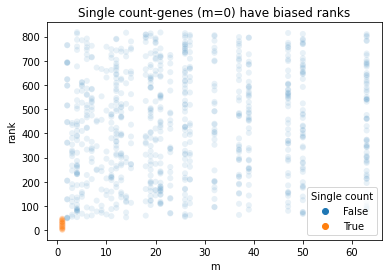

In [9]:
plot_df = spot_ranks[
    spot_ranks['filtering'].eq('unfilt') &
    spot_ranks['cell_id'].eq('98094925393968329130254909503130262661')
].copy()
plot_df['Single count'] = plot_df['m'].eq(1)

ax = sns.scatterplot(
    x = 'm',
    y = 'rank',
    alpha = 0.1,
    hue = 'Single count',
    data = plot_df,
)
ax.set_title('Unfiltered, Single count-genes (m=0) have biased ranks')
plt.show()
plt.close()

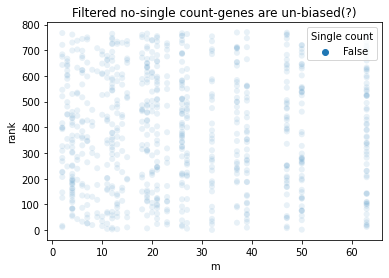

In [12]:
plot_df = spot_ranks[
    spot_ranks['filtering'].eq('filt') &
    spot_ranks['cell_id'].eq('98094925393968329130254909503130262661')
].copy()
plot_df['Single count'] = plot_df['m'].eq(1)

ax = sns.scatterplot(
    x = 'm',
    y = 'rank',
    alpha = 0.1,
    hue = 'Single count',
    data = plot_df,
)
ax.set_title('Filtered no-single count-genes are un-biased(?)')
plt.show()
plt.close()

# Formalizing test for punctate bias by gene-count

Now that I've applied the filtering, I can visually see that the bias might be removed

But how can I quantitatively be sure?

I'm going to start by plotting punctate score vs gene/fraction from all cells and see if it "looks correct"

In [62]:
score_df = pd.concat(scoring.iter_scores(filt_scored_cells, metric='radial'),ignore_index=True)
score_df

,metric,cell_id,annotation,num_spots,gene,num_gene_spots,median_rank,score,variance
0,radial,104773525917171323315032845506736864421,L45_IT_1,288,Cdh12,12,144.0,0.003484,0.063849
1,radial,104773525917171323315032845506736864421,L45_IT_1,288,Rorb,18,85.0,0.414634,0.044873
2,radial,104773525917171323315032845506736864421,L45_IT_1,288,Prdm8,7,61.0,0.581882,0.109546
3,radial,104773525917171323315032845506736864421,L45_IT_1,288,Lsp1,2,110.5,0.236934,0.167243
4,radial,104773525917171323315032845506736864421,L45_IT_1,288,Nr4a1,7,128.5,0.111498,0.109546
...,...,...,...,...,...,...,...,...,...
4394,radial,98094925393968329130254909503130262661,L5_IT_2,770,Rgs5,4,519.5,-0.348505,0.133159
4395,radial,98094925393968329130254909503130262661,L5_IT_2,770,Sgcd,2,108.5,0.720416,0.166883
4396,radial,98094925393968329130254909503130262661,L5_IT_2,770,Cntnap5b,4,627.0,-0.628088,0.133159
4397,radial,98094925393968329130254909503130262661,L5_IT_2,770,Sertm1,2,166.5,0.569571,0.166883


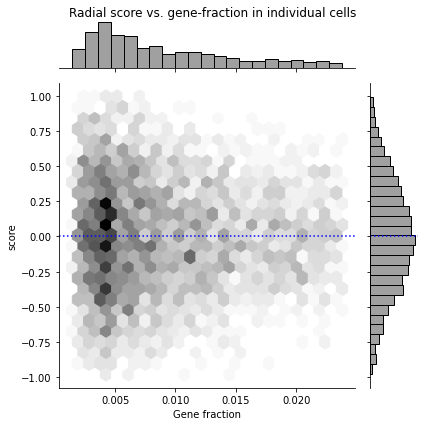

In [63]:
score_df['Gene fraction'] = score_df['num_gene_spots'].div(score_df['num_spots'])
max_frac = score_df['Gene fraction'].quantile(0.8)

p = sns.jointplot(
    x = 'Gene fraction',
    y = 'score',
    kind = 'hex',
    color = 'grey',
    data = score_df[score_df['Gene fraction'].le(max_frac)],
)

p.ax_joint.axhline(0,linestyle='dotted',color='blue')
p.ax_marg_y.axhline(0,linestyle='dotted',color='blue')

#p.ax_joint.set_xlim(0,max_frac)

p.fig.suptitle('Radial score vs. gene-fraction in individual cells')
p.fig.tight_layout()
p.fig.subplots_adjust(top=0.95) # Reduce plot to make room #got code from https://stackoverflow.com/questions/60358228/how-to-set-title-on-seaborn-jointplot

plt.show()
plt.close()

the plot does "look" correct, but maybe I can visualize in a different way by binning the gene fractions and plotting CDFs

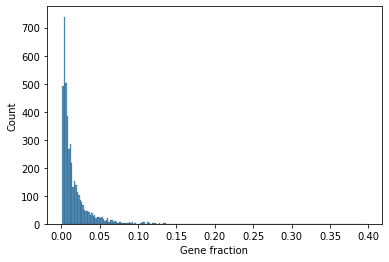

In [44]:
sns.histplot(score_df['Gene fraction'])
plt.show()
plt.close()

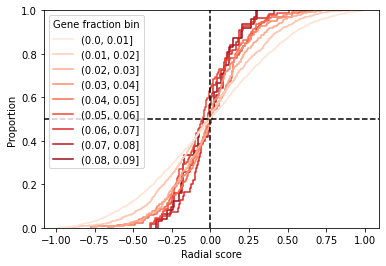

In [65]:
bins = np.arange(0,0.1,0.01)

score_df['Gene fraction bin'] = pd.cut(score_df['Gene fraction'], bins=bins)
ax = sns.ecdfplot(
    x = 'score',
    hue = 'Gene fraction bin',
    palette = 'Reds',
    data = score_df,
)
ax.axhline(0.5, linestyle='dashed', color='black')
ax.axvline(0.0, linestyle='dashed', color='black')
plt.xlabel('Radial score')
plt.show()
plt.close()

# "Choose two" bootstrapping punctate metric

In [142]:
import importlib
import SRRS
from SRRS import metrics, plotting, scoring, simulate

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [143]:
sample = SRRS.HDF5('../inputs/filtered_out_one_gene_counts/mouse1sample1.hdf5')
sample

HDF5 ../inputs/filtered_out_one_gene_counts/mouse1sample1.hdf5

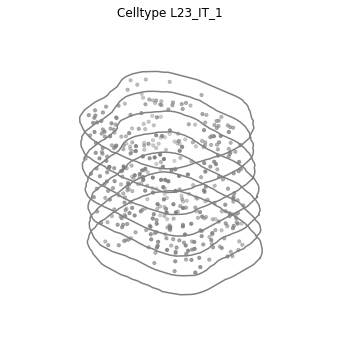

In [150]:
iter_cells = sample.iter_cells()
cell = next(iter_cells)
cell = next(iter_cells)
cell = next(iter_cells)
cell = next(iter_cells)
cell = next(iter_cells)
cell = next(iter_cells)
cell = next(iter_cells)

fig,ax = plotting.plot_cell_3D(cell)
plt.show()
plt.close()

In [153]:
len(cell.genes)

52

In [182]:
importlib.reload(metrics)

<module 'SRRS.metrics' from '/oak/stanford/groups/horence/rob/isoform_localizations/SRRS/src/SRRS/metrics.py'>

In [183]:
%%time
cell.ranked = False
df = metrics.punctate(cell, num_iterations=1000)
df

CPU times: user 1.51 s, sys: 22 ms, total: 1.53 s
Wall time: 1.53 s


gene
Bdnf        0.215686
Brinp3     -0.294118
C1ql3       0.019608
Calb2       0.098039
Camk2d      0.137255
Cbln2      -0.137255
Ccbe1      -0.529412
Ccdc3       0.294118
Cdh12       0.215686
Cdh13       0.450980
Cemip       0.529412
Chrm2      -0.176471
Col25a1    -0.098039
Ctss       -0.803922
Cux2        0.176471
Cxcl14      0.803922
Dscaml1     0.019608
Epha7      -0.019608
Gfap       -0.843137
Gpc6        0.725490
Grm1       -0.450980
Grm8        0.098039
Igfbp4     -0.019608
Igfbp5      0.058824
Iqgap2     -0.215686
Itgb8      -0.764706
Kcng1      -0.137255
Meis2       0.019608
Nos1        0.490196
Npnt       -0.019608
Nr4a1       0.137255
Ntng2      -0.490196
Otof        0.039216
Pou3f1     -0.137255
Pou3f3      0.254902
Prdm8      -0.254902
Ptprk       0.019608
Ptprt       0.411765
Ptpru       0.215686
Ramp1      -0.176471
Rgs6       -0.058824
Satb2       0.098039
Sertm1      0.294118
Shisa9      0.568627
Slc30a3     0.019608
Syndig1     0.019608
Thsd7a     -0.450980
Trp53i11

In [184]:
# testing if there is bias in the "choose 2" approach by permuting gene labels
df = pd.Series(dtype='float64')
df.index.name = 'gene'

for i in range(1000):
    if i%10 == 0:
        print(i)
        
    cell = simulate.null_permute_gene_labels(cell, within_z=False)
    scores = metrics.punctate(cell, num_iterations=100)
    
    df = pd.concat((df,scores))
    
df = df.reset_index(name='score')
df

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990


,gene,score
0,Bdnf,-0.450980
1,Brinp3,-0.098039
2,C1ql3,0.215686
3,Calb2,-0.529412
4,Camk2d,0.098039
...,...,...
51995,Trp53i11,-0.254902
51996,Trpc4,-0.725490
51997,Trpc6,0.156863
51998,Unc5d,-0.215686


In [169]:
df.shape

(52000, 3)

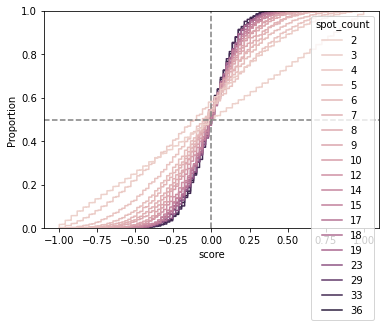

In [168]:
df['spot_count'] = df['gene'].map(cell.gene_counts)

sns.ecdfplot(
    x = 'score',
    hue = 'spot_count',
    data = df,
)
plt.axhline(0.5,linestyle='dashed',color='grey')
plt.axvline(0.0,linestyle='dashed',color='grey')
plt.show()
plt.close()

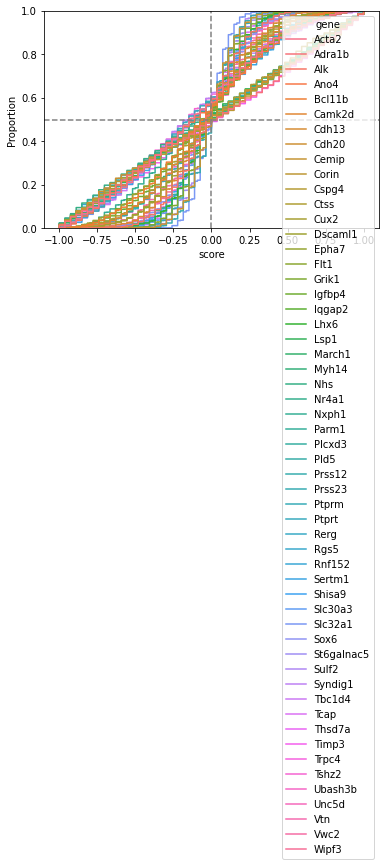

In [75]:
df['spot_count'] = df['gene'].map(cell.gene_counts)

sns.ecdfplot(
    x = 'score',
    hue = 'gene',
    data = df,
)
plt.axhline(0.5,linestyle='dashed',color='grey')
plt.axvline(0.0,linestyle='dashed',color='grey')
plt.show()
plt.close()

## Searching for bug in "pick-two" code that could be leading to bias on null

In [42]:
import random
import numpy as np
import collections

In [41]:
cell.gene_counts

Counter({'Acta2': 3,
         'Tbc1d4': 3,
         'Ptprt': 3,
         'Tshz2': 3,
         'Prss12': 3,
         'Ano4': 3,
         'Sertm1': 3,
         'Thsd7a': 3,
         'Syndig1': 3})

In [53]:
len(cell.genes)

9

In [52]:
gene_ranks_df

,gene,rank
0,Acta2,9
1,Ano4,7
2,Prss12,6
3,Ptprt,3
4,Sertm1,2
5,Syndig1,1
6,Tbc1d4,5
7,Thsd7a,4
8,Tshz2,8


In [55]:
gene_dists

[(172.10409439249472, 'Acta2'),
 (66.30708837249928, 'Ano4'),
 (70.75418372000176, 'Prss12'),
 (5.966150762498909, 'Ptprt'),
 (5.733153699999924, 'Sertm1'),
 (2.5424507881017897, 'Syndig1'),
 (282.25773883040483, 'Tbc1d4'),
 (17.31714391250069, 'Thsd7a'),
 (208.13796687289906, 'Tshz2')]

[('Syndig1', 0),
 ('Sertm1', 1),
 ('Ptprt', 2),
 ('Thsd7a', 3),
 ('Ano4', 4),
 ('Prss12', 5),
 ('Acta2', 6),
 ('Tshz2', 7),
 ('Tbc1d4', 8)]

In [75]:
num_iterations = 1000

spot_gene_coords = [
    (g,(x,y)) for z in cell.zslices
    for g,(x,y) in zip(cell.spot_genes[z],cell.spot_coords[z])
]

gene_ranks = {g:[] for g in cell.genes}

for i in range(num_iterations):
    #shuffle the spot order
    random.shuffle(spot_gene_coords)

    #choose two spots from each gene to be representatives (NOTE can do this more efficiently!)
    g_reps = {g:[] for g in cell.genes}
    for gene,xy in spot_gene_coords:
        if len(g_reps[gene]) < 2:
            g_reps[gene].append(xy)

    #measure x,y euclidean distance between two spots (NOTE ignoring z)
    gene_dists = []
    for gene in g_reps:
        x1,y1 = g_reps[gene][0]
        x2,y2 = g_reps[gene][1]
        dist = (x1-x2)*(x1-x2)+(y1-y2)*(y1-y2)
        gene_dists.append((dist,gene))
    
    #rank by sorting and store results
    for i,(d,g) in enumerate(sorted(gene_dists)):
        gene_ranks[g].append(i+1)
        
#Calculate the per-gene score
exp_med_rank = (len(cell.genes)+1)/2
obs_med_ranks = [np.mean(gene_ranks[gene]) for gene in cell.genes]
gene_scores = map(lambda o: (exp_rank-o)/(exp_rank-1), obs_med_ranks)

score_df = pd.DataFrame({
    'gene':cell.genes,
    'obs_med_rank':obs_med_ranks,
    'score':gene_scores
})

score_df

,gene,obs_med_rank,score
0,Acta2,6.091,-0.27275
1,Ano4,4.238,0.19050
2,Prss12,6.629,-0.40725
3,Ptprt,3.401,0.39975
4,Sertm1,1.837,0.79075
5,Syndig1,5.020,-0.00500
6,Tbc1d4,7.072,-0.51800
7,Thsd7a,4.338,0.16550
8,Tshz2,6.374,-0.34350


In [76]:
exp_rank

5.0

In [77]:
score_df['score'].mean()

2.4671622769447922e-17

In [48]:
np.array(dists)

array([172.10409439,  58.78671009,  51.89382949,   5.96615076,
         4.377104  ,   2.54245079,  43.94281551,  42.20976677,
        60.22222718])

In [49]:
np.array(dists).argsort()

array([5, 4, 3, 7, 6, 2, 1, 8, 0])

In [50]:
np.array(dists).argsort().argsort()+1

array([8, 6, 5, 2, 1, 0, 4, 3, 7])

In [46]:
dists

[172.10409439249472,
 58.78671009249979,
 51.89382948999822,
 5.966150762498909,
 4.377104000000055,
 2.5424507881017897,
 43.942815512499095,
 42.2097667681013,
 60.222227180897995]

In [44]:
spot_usage = pd.DataFrame(all_rep_spots, columns=['gene','x','y']).groupby(['gene','x','y']).size().reset_index(name='count')
spot_usage

,gene,x,y,count
0,Acta2,804.12300,-3143.1138,672
1,Acta2,807.19750,-3150.8486,659
2,Acta2,811.45795,-3153.9905,669
3,Ano4,802.79755,-3147.5361,655
4,Ano4,809.47600,-3143.7698,680
5,Ano4,810.69630,-3145.5570,665
6,Prss12,804.19720,-3143.1956,653
7,Prss12,811.31710,-3152.6394,680
8,Prss12,812.28660,-3145.5012,667
9,Ptprt,808.77966,-3143.8103,691


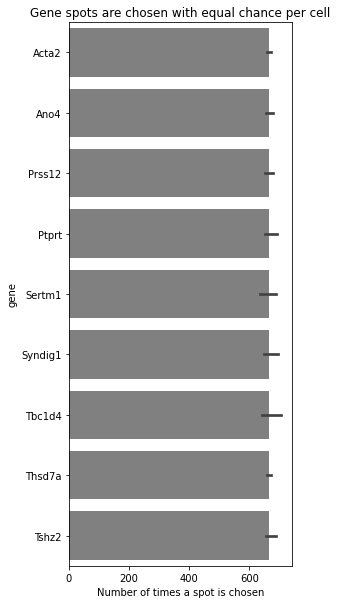

In [45]:
gene_order = spot_usage['gene'].value_counts().index

fig = plt.figure(figsize=(4,10))
sns.barplot(
    x = 'count',
    y = 'gene',
    color = 'grey',
    order = gene_order,
    data = spot_usage,
)
plt.title('Gene spots are chosen with equal chance per cell')
plt.xlabel('Number of times a spot is chosen')
plt.show()
plt.close()

In [91]:
spot_gene_coords

[('Wipf3', (805.7313, -3148.8867)),
 ('Alk', (806.221, -3145.425)),
 ('Sulf2', (808.8317, -3152.4675)),
 ('Nxph1', (809.5845, -3149.0754)),
 ('Prss23', (802.50226, -3145.0718)),
 ('Grik1', (806.4645, -3141.6284)),
 ('Tcap', (807.325, -3151.7593)),
 ('St6galnac5', (808.8038, -3143.9294)),
 ('Lsp1', (808.0472, -3144.1162)),
 ('Cdh13', (803.6323, -3143.4536)),
 ('Prss12', (804.42645, -3148.4866)),
 ('Corin', (803.7255, -3144.7656)),
 ('Cux2', (804.702, -3148.3523)),
 ('Syndig1', (805.0558, -3143.9048)),
 ('Slc32a1', (807.95416, -3147.1646)),
 ('Ptprm', (808.0586, -3140.8691)),
 ('Prss23', (810.6515, -3152.0396)),
 ('Slc32a1', (810.9376, -3146.2297)),
 ('Acta2', (812.2866, -3145.5012)),
 ('Wipf3', (804.13544, -3148.5845)),
 ('Lhx6', (810.0318, -3151.6006)),
 ('Ctss', (808.71844, -3150.4736)),
 ('Sulf2', (804.9407, -3149.868)),
 ('Iqgap2', (802.5319999999998, -3145.812)),
 ('Slc32a1', (807.6315, -3143.3599)),
 ('Ctss', (810.3218400000002, -3156.6704)),
 ('Shisa9', (809.8874, -3149.7786)),
 

In [179]:
plotting.plot_cell_zslices?

In [180]:
importlib.reload(plotting)

<module 'SRRS.plotting' from '/oak/stanford/groups/horence/rob/isoform_localizations/SRRS/src/SRRS/plotting.py'>

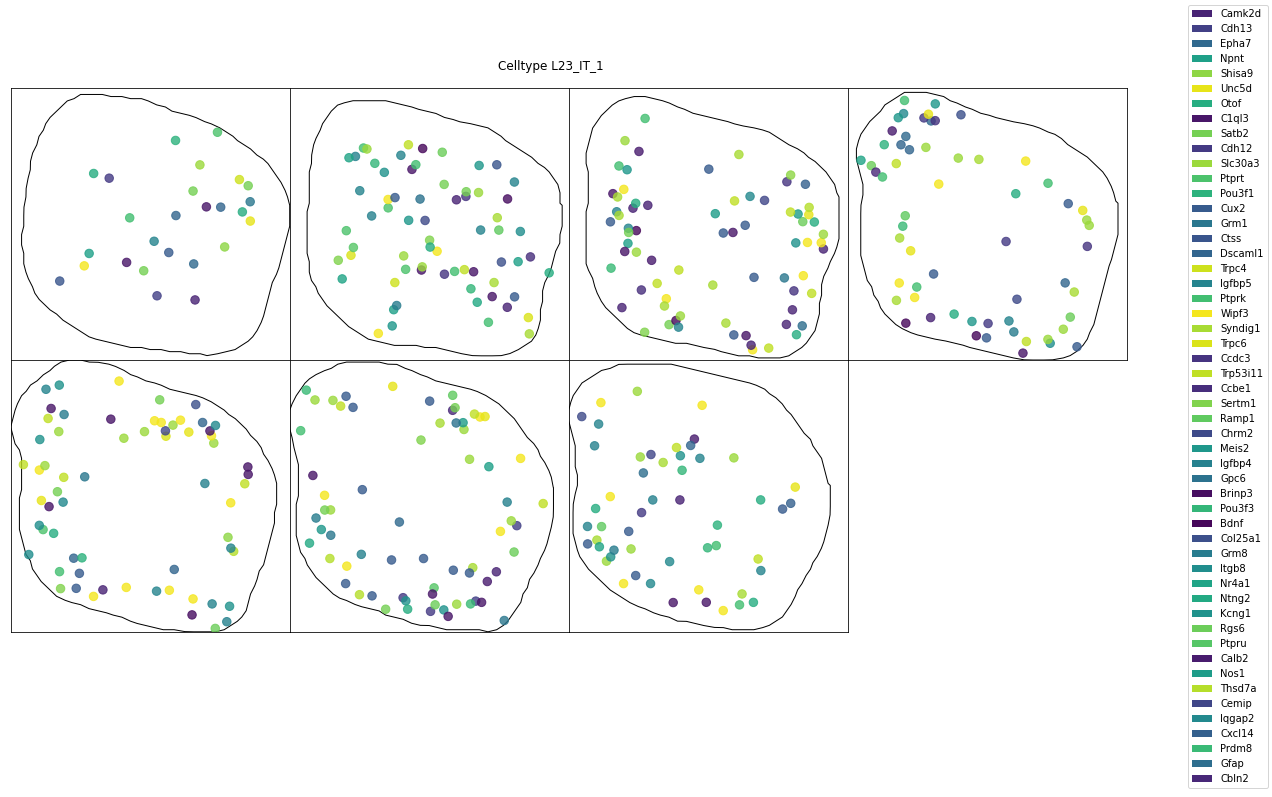

In [181]:
num_genes = len(cell.genes)
cs = sns.color_palette('viridis',num_genes)
gcs = {g:c for g,c in zip(cell.genes,cs)}

fig,ax = plotting.plot_cell_zslices(cell, gene_colors=gcs)
plt.show()
plt.close()

## "Pick two" punctate score filtering to have different numbers of genes/counts

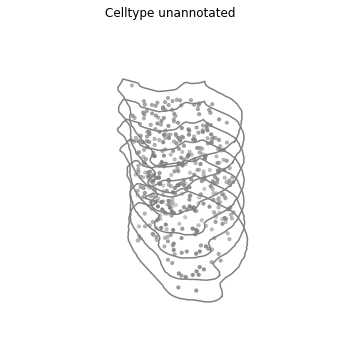

In [2]:
import importlib
import copy

import SRRS
from SRRS import metrics, plotting, scoring, simulate

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

importlib.reload(SRRS)
importlib.reload(metrics)

sample = SRRS.HDF5('../inputs/filtered_out_one_gene_counts/mouse1sample1.hdf5')

iter_cells = sample.iter_cells()
cell = next(iter_cells)
#cell = next(iter_cells)
#cell = next(iter_cells)
#cell = next(iter_cells)
#cell = next(iter_cells)
#cell = next(iter_cells)
#cell = next(iter_cells)

orig_cell = copy.deepcopy(cell)

fig,ax = plotting.plot_cell_3D(cell)
plt.show()
plt.close()

In [9]:
len(sample.cells())

[Cell-100002246487729891775754092425114477436-unannotated,
 Cell-100006592165978924204028942520409194775-unannotated,
 Cell-100040857293507150543672434367851019344-unannotated,
 Cell-100078777556413476689405249469750752562-L6_IT_3,
 Cell-100087079604313040350903416512866875178-L23_IT_4,
 Cell-100091009396667473995136644963828192189-L6_IT_1,
 Cell-100108828220225876033423665776317861925-L23_IT_4,
 Cell-100129264771631286596562859385145960309-L23_IT_1,
 Cell-10019604646421702730270746826811184624-L5_ET_1,
 Cell-100242074071913350783057156494937594133-unannotated,
 Cell-10032793791539981569759397028350596090-L23_IT_1,
 Cell-100340335819132181432875565628414879129-L5_ET_2,
 Cell-100351149343297639462646801319585689666-L45_IT_1,
 Cell-100357557613983092542421396030726393144-L23_IT_1,
 Cell-100380053694628080154765566294325609353-unannotated,
 Cell-100400866526847287182036164464559227806-unannotated,
 Cell-10042468813034150325354226896590217644-Sst_1,
 Cell-1004375681200196009276529361900092

In [ ]:
%%time
importlib.reload(simulate)

simulate.gene_cell_sim_null_peripheral(
    cells = sample.cells(),
    metric = 'peripheral',
    within_z = False,
    n_its = 20,
    processes = 1,
)

Process ForkPoolWorker-462:
Traceback (most recent call last):
  File "/share/software/user/open/python/3.9.0/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/share/software/user/open/python/3.9.0/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/share/software/user/open/python/3.9.0/lib/python3.9/multiprocessing/pool.py", line 131, in worker
    put((job, i, result))
  File "/share/software/user/open/python/3.9.0/lib/python3.9/multiprocessing/queues.py", line 378, in put
    self._writer.send_bytes(obj)
  File "/share/software/user/open/python/3.9.0/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/share/software/user/open/python/3.9.0/lib/python3.9/multiprocessing/connection.py", line 410, in _send_bytes
    self._send(buf)
  File "/share/software/user/open/python/3.9.0/lib/python3.9/multiprocessing/conne

KeyboardInterrupt: 

KeyboardInterrupt
Process ForkPoolWorker-464:
Traceback (most recent call last):
  File "/share/software/user/open/python/3.9.0/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/share/software/user/open/python/3.9.0/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/share/software/user/open/python/3.9.0/lib/python3.9/multiprocessing/pool.py", line 131, in worker
    put((job, i, result))
  File "/share/software/user/open/python/3.9.0/lib/python3.9/multiprocessing/queues.py", line 378, in put
    self._writer.send_bytes(obj)
  File "/share/software/user/open/python/3.9.0/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/share/software/user/open/python/3.9.0/lib/python3.9/multiprocessing/connection.py", line 416, in _send_bytes
    self._send(header + buf)
  File "/share/software/user/open/python/3.9.0/lib/pyth

In [360]:
#remove all genes which don't have 3 spots (occurs in place)
#cell.filter_genes_by_count(min_gene_spots=3, max_gene_spots=3)

In [361]:
cell.gene_counts

Counter({'Prss23': 24,
         'Ptprm': 17,
         'Igfbp4': 4,
         'Acta2': 3,
         'Slc32a1': 52,
         'Slc30a3': 11,
         'Cux2': 6,
         'Nxph1': 4,
         'St6galnac5': 16,
         'Sulf2': 22,
         'Camk2d': 5,
         'Grik1': 14,
         'Bcl11b': 4,
         'Cemip': 22,
         'Lhx6': 11,
         'Dscaml1': 4,
         'Iqgap2': 4,
         'Rgs5': 11,
         'Shisa9': 9,
         'Tbc1d4': 3,
         'Tcap': 12,
         'Ubash3b': 9,
         'Unc5d': 5,
         'Vtn': 7,
         'Cspg4': 2,
         'Ptprt': 3,
         'Alk': 9,
         'Rerg': 5,
         'Parm1': 9,
         'Lsp1': 2,
         'Nhs': 2,
         'Rnf152': 2,
         'Sox6': 8,
         'Trpc4': 9,
         'Tshz2': 3,
         'Vwc2': 6,
         'Prss12': 3,
         'Cdh13': 7,
         'Ano4': 3,
         'Timp3': 2,
         'Wipf3': 7,
         'Flt1': 6,
         'Sertm1': 3,
         'Corin': 2,
         'Pld5': 2,
         'Ctss': 5,
         'Thsd7a':

In [463]:
%%time
importlib.reload(metrics)
scores = metrics.punctate(cell, num_iterations=1000, num_pairs=4)

CPU times: user 1.55 s, sys: 3.6 ms, total: 1.56 s
Wall time: 1.81 s


In [466]:
%%time
#create null background of cells to test for biases
# testing if there is bias in the approach by permuting gene labels on this filtered cell
df = pd.DataFrame()

num_cells = 1000
num_label_swaps = 100
num_choose_two_perms = 4

df = pd.DataFrame()

for i in range(num_cells):
    if i%10 == 0:
        print(i)
        
    cell = simulate.null_permute_gene_labels(cell, within_z=False)
    scores = metrics.punctate(cell, num_iterations=num_label_swaps, num_pairs=num_choose_two_perms)
        
    df = pd.concat((df,scores))
    
df

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
CPU times: user 2min 45s, sys: 732 ms, total: 2min 45s
Wall time: 2min 44s


,gene,spot_count,score,var
0,Prss23,24,-0.78,0.001318
1,Ptprm,17,0.70,0.001014
2,Igfbp4,4,-0.98,0.001755
3,Acta2,3,0.92,0.003926
4,Slc32a1,52,-0.44,0.001189
...,...,...,...,...
50,Myh14,5,0.70,0.001552
51,Epha7,2,0.36,0.005996
52,Nr4a1,2,0.36,0.005996
53,Syndig1,3,-0.48,0.002651


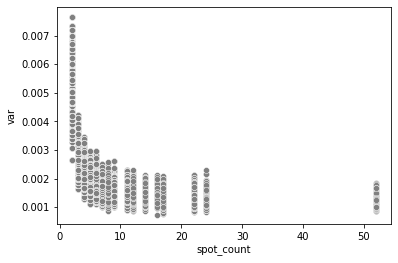

In [467]:
#I'm expecting to see more variance for genes with fewer counts
#The variances seem low, but I don't know why I say that
#The values can only be between -1 and 1
sns.scatterplot(
    x = 'spot_count',
    y = 'var',
    color = 'grey',
    data = df,
)
plt.show()
plt.close()

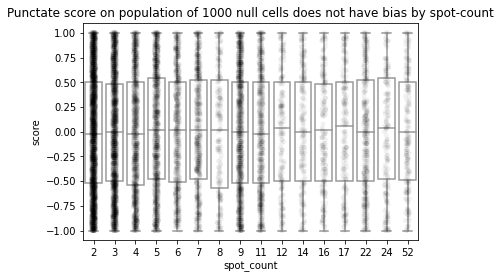

In [468]:
#On this simulated dataset, expect each spot-count to have the same distribution of scores
sns.boxplot(
    x = 'spot_count',
    y = 'score',
    color = 'white',
    data = df,
)
sns.stripplot(
    x = 'spot_count',
    y = 'score',
    color = 'black',
    alpha = 0.05,
    data = df.sample(10000),
)
plt.title('Punctate score on population of 1000 null cells does not have bias by spot-count')
plt.show()
plt.close()

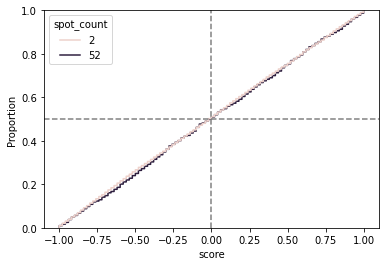

In [469]:
sns.ecdfplot(
    x = 'score',
    hue = 'spot_count',
    data = df[df['spot_count'].isin([2,52])].reset_index(),
)
plt.axhline(0.5, linestyle='dashed', color='grey')
plt.axvline(0, linestyle='dashed', color='grey')
plt.show()
plt.close()

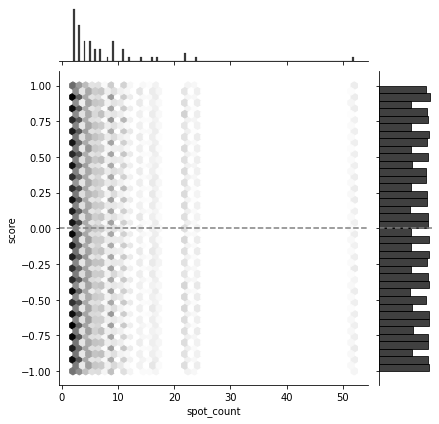

In [449]:
g = sns.jointplot(
    x = 'spot_count',
    y = 'score',
    kind = 'hex',
    color = 'black',
    data = df.reset_index(drop=True),
)

g.ax_joint.axhline(0,linestyle='dashed',color='grey')
g.ax_marg_y.axhline(0,linestyle='dashed',color='grey')

plt.show()
plt.close()

In [451]:
df.head()

,gene,spot_count,score,var
0,Prss23,24,0.56,0.001239
1,Ptprm,17,0.90,0.001154
2,Igfbp4,4,1.00,0.002596
3,Acta2,3,-0.26,0.003678
4,Slc32a1,52,-0.44,0.001365


# Output from permutation-based punctate scores on real data

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

df = pd.read_csv('../punctate_refactored_mouse1sample1.csv')
df.head()

,metric,cell_id,annotation,num_spots,gene,num_gene_spots,score,variance
0,puncta,222098490380092065288492113826920653088,L23_IT_1,470,C1ql3,12,-0.070,0.000011
1,puncta,222098490380092065288492113826920653088,L23_IT_1,470,Bmpr1b,3,-0.218,0.000023
2,puncta,222098490380092065288492113826920653088,L23_IT_1,470,Sertm1,5,0.366,0.000017
3,puncta,222098490380092065288492113826920653088,L23_IT_1,470,Rgs6,16,0.258,0.000011
4,puncta,222098490380092065288492113826920653088,L23_IT_1,470,Meis2,11,0.120,0.000011


In [5]:
print(df['cell_id'].nunique(),'cells')
print(df['gene'].nunique(),'genes')

17185 cells
252 genes


In [8]:
df['num_gene_spots'].nunique()

207

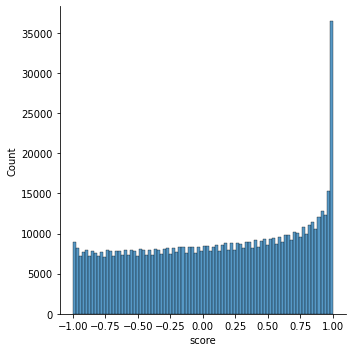

In [13]:
sns.displot(
    x = 'score',
    data = df,
)
plt.show()
plt.close()

In [16]:
df[df['score'].eq(1)]

,metric,cell_id,annotation,num_spots,gene,num_gene_spots,score,variance
48,puncta,222098490380092065288492113826920653088,L23_IT_1,470,Aqp4,2,1.0,0.000038
50,puncta,222098490380092065288492113826920653088,L23_IT_1,470,Rorb,3,1.0,0.000023
63,puncta,222098490380092065288492113826920653088,L23_IT_1,470,Ptprm,2,1.0,0.000038
71,puncta,141218692055126956427744850085979601892,unannotated,129,Rgs5,16,1.0,0.000009
75,puncta,141218692055126956427744850085979601892,unannotated,129,Cdh12,2,1.0,0.000032
...,...,...,...,...,...,...,...,...
768879,puncta,170383754291204721273673821491834994948,L56_NP_2,477,Nhs,2,1.0,0.000034
768932,puncta,148075930701215688697532992176897501747,L23_IT_4,406,Cdh13,2,1.0,0.000074
769150,puncta,274189011369437347316203687060648905403,unannotated,441,Flt1,5,1.0,0.000016
769184,puncta,274189011369437347316203687060648905403,unannotated,441,Zfp804b,2,1.0,0.000045


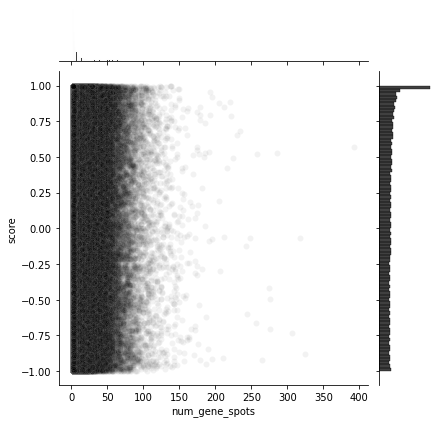

In [12]:
sns.jointplot(
    x = 'num_gene_spots',
    y = 'score',
    color = 'black',
    alpha = 0.05,
    data = df,
)
plt.show()
plt.close()

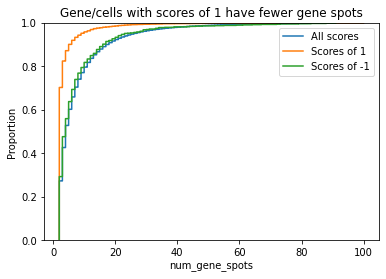

In [25]:
sns.ecdfplot(
    x = 'num_gene_spots',
    label = 'All scores',
    data = df[df['num_gene_spots'].le(100)],
)
sns.ecdfplot(
    x = 'num_gene_spots',
    label = 'Scores of 1',
    data = df[df['num_gene_spots'].le(100) & df['score'].eq(1)],
)
sns.ecdfplot(
    x = 'num_gene_spots',
    label = 'Scores of -1',
    data = df[df['num_gene_spots'].le(100) & df['score'].eq(-1)],
)
plt.legend()
plt.title('Gene/cells with scores of 1 have fewer gene spots')
plt.show()
plt.close()

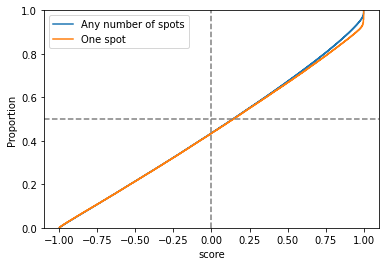

In [31]:
sns.ecdfplot(
    x = 'score',
    label = 'Any number of spots',
    data = df,
)

sns.ecdfplot(
    x = 'score',
    label = 'One spot',
    data = df[df['num_gene_spots'].eq(2)],
)

plt.axhline(0.5, linestyle='dashed', color='grey')
plt.axvline(0.0, linestyle='dashed', color='grey')
plt.legend()
plt.show()
plt.close()

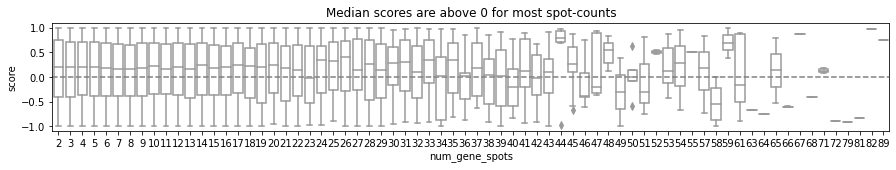

In [42]:
fig = plt.figure(figsize=(15,2))
sns.boxplot(
    x = 'num_gene_spots',
    y = 'score',
    color = 'white',
    data = df[df['num_spots'].le(150)],
)
plt.axhline(0.0, linestyle='dashed', color='grey')
plt.title('Median scores are above 0 for most spot-counts')
plt.show()
plt.close()

In [44]:
#visualizing some of the extreme gene/cell scores
import SRRS
from SRRS import plotting

sample = SRRS.HDF5('/oak/stanford/groups/horence/rob/isoform_localizations/SRRS/inputs/mouse1sample1.hdf5')
sample

HDF5 /oak/stanford/groups/horence/rob/isoform_localizations/SRRS/inputs/mouse1sample1.hdf5

### all these gene/cells have a score of 1 (very punctate

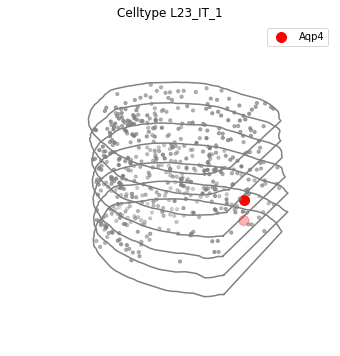

In [54]:
cell = sample.get_cells_by_id(['222098490380092065288492113826920653088'])[0]
fig,ax = plotting.plot_cell_3D(cell, gene_colors={'Aqp4':'red'})
plt.show()
plt.close()

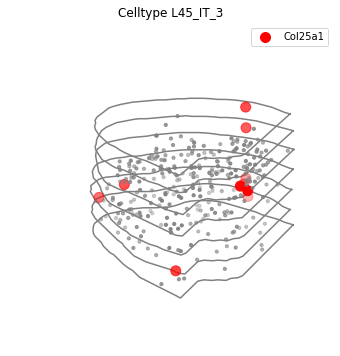

In [52]:
cell = sample.get_cells_by_id(['86160538687897987056485308143342788364'])[0]
fig,ax = plotting.plot_cell_3D(cell, gene_colors={'Col25a1':'red'})
plt.show()
plt.close()

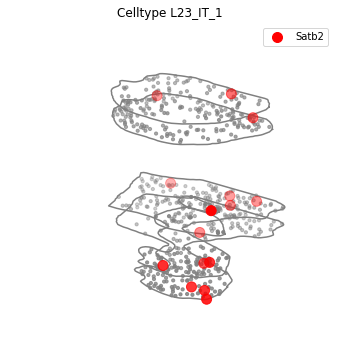

In [51]:
cell = sample.get_cells_by_id(['227833902103094513653469756064354589296'])[0]
fig,ax = plotting.plot_cell_3D(cell, gene_colors={'Satb2':'red'})
plt.show()
plt.close()

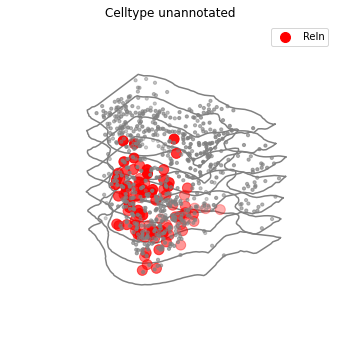

In [49]:
cell = sample.get_cells_by_id(['5920985237459637946126883927110494777'])[0]
fig,ax = plotting.plot_cell_3D(cell, gene_colors={'Reln':'red'})
plt.show()
plt.close()

### all of these gene/cells have a score of -1

In [66]:
df[df['score'].eq(1) & df['num_gene_spots'].eq(10)]

,metric,cell_id,annotation,num_spots,gene,num_gene_spots,score,variance
1109,puncta,123121945908935795889427351670672710409,unannotated,514,Cspg4,10,1.0,0.000015
8833,puncta,86160538687897987056485308143342788364,L45_IT_3,285,Col25a1,10,1.0,0.000006
13709,puncta,138620132974349161563120191897657376431,L6_CT_4,436,Adra1b,10,1.0,0.000011
39027,puncta,36246076708363684013428675880600628271,L5_IT_1,814,Mrc1,10,1.0,0.000023
49062,puncta,42187832802052240813351218075560893003,unannotated,91,Npnt,10,1.0,0.000143
...,...,...,...,...,...,...,...,...
690113,puncta,70209735213405083786083486335471551552,SMC,369,Cemip,10,1.0,0.000026
727167,puncta,268023922925846628659647176017992033653,OPC,205,Rgs5,10,1.0,0.000016
728455,puncta,222304125514080535762301096439583639522,VLMC,326,Mrc1,10,1.0,0.000020
737825,puncta,217567338373157551189554837352677863999,unannotated,455,Unc5b,10,1.0,0.000017


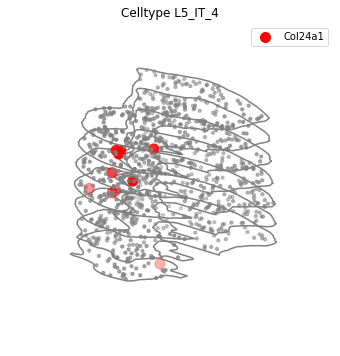

In [68]:
cell = sample.get_cells_by_id(['176207460594798926125106281154597702567'])[0]
fig,ax = plotting.plot_cell_3D(cell, gene_colors={'Col24a1':'red'})
plt.show()
plt.close()

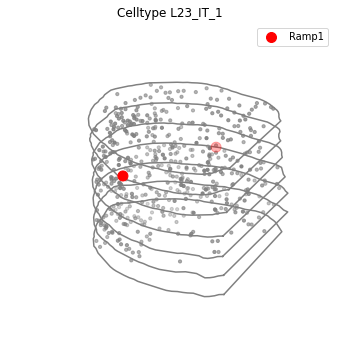

In [57]:
cell = sample.get_cells_by_id(['222098490380092065288492113826920653088'])[0]
fig,ax = plotting.plot_cell_3D(cell, gene_colors={'Ramp1':'red'})
plt.show()
plt.close()

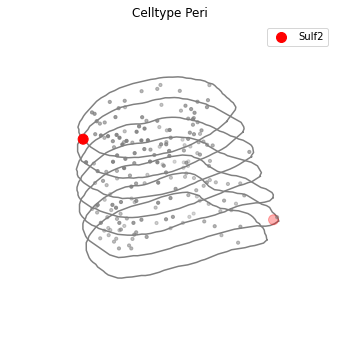

In [58]:
cell = sample.get_cells_by_id(['20412369700126259876450951845622773712'])[0]
fig,ax = plotting.plot_cell_3D(cell, gene_colors={'Sulf2':'red'})
plt.show()
plt.close()

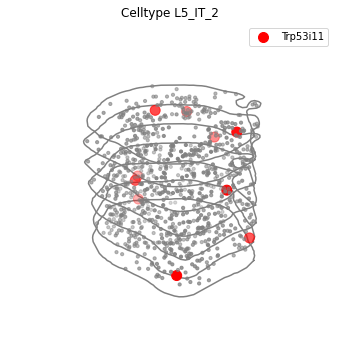

In [60]:
cell = sample.get_cells_by_id(['120119137789607729623614875913849203969'])[0]
fig,ax = plotting.plot_cell_3D(cell, gene_colors={'Trp53i11':'red'})
plt.show()
plt.close()

## Output from permutation-based punctate score on permuted data (not real!)

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

df = pd.read_csv('../null_permute_punctate_refactored_mouse1sample2.csv')
df.head()

,metric,cell_id,annotation,num_spots,gene,num_gene_spots,score,variance
0,puncta,151692919632475502111091497544545894854,L6_CT_3,206,Luzp2,2,0.776,0.000019
1,puncta,151692919632475502111091497544545894854,L6_CT_3,206,Rfx3,4,-0.270,0.000008
2,puncta,151692919632475502111091497544545894854,L6_CT_3,206,Fezf2,5,-0.922,0.000007
3,puncta,151692919632475502111091497544545894854,L6_CT_3,206,Meis2,21,-0.356,0.000005
4,puncta,151692919632475502111091497544545894854,L6_CT_3,206,Parm1,3,-0.892,0.000010


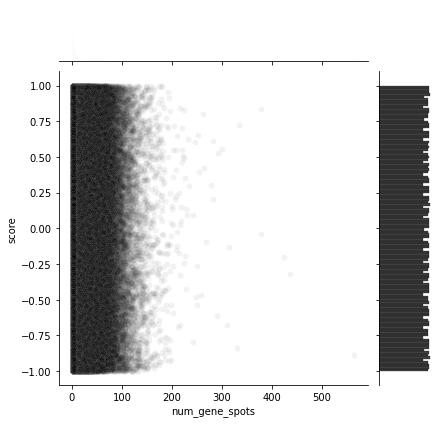

In [2]:
sns.jointplot(
    x = 'num_gene_spots',
    y = 'score',
    color = 'black',
    alpha = 0.05,
    data = df,
)
plt.show()
plt.close()

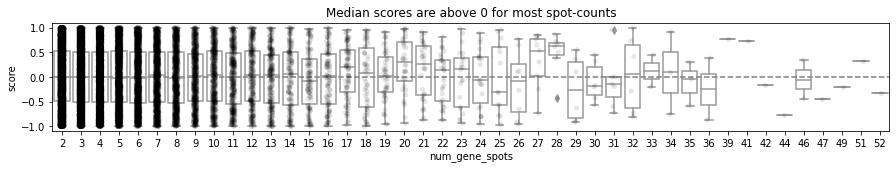

In [9]:
fig = plt.figure(figsize=(15,2))
sns.boxplot(
    x = 'num_gene_spots',
    y = 'score',
    color = 'white',
    data = df[df['num_spots'].le(100)],
)
sns.stripplot(
    x = 'num_gene_spots',
    y = 'score',
    color = 'black',
    alpha = 0.1,
    data = df[df['num_spots'].le(100)],
)
plt.axhline(0.0, linestyle='dashed', color='grey')
plt.title('Median scores are above 0 for most spot-counts')
plt.show()
plt.close()